# TMA Performance Settings vs Capacitor Bank discharge [SITCOM-1146]

Parker Fagrelius  
Jan. 30, 2024

https://jira.lsstcorp.org/browse/SITCOM-1146

We want to compare the maximum velocity, acceleration and jerk on every slew with the minimum value of the capacitor banks on the TMA. 

Phase, the contractor responsible for the TMA Power Supply and the Capacitor Banks, suggests that we keep these voltage drops above 575 V. 

### Setup

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

from lsst_efd_client import EfdClient, resample
from lsst.summit.utils.tmaUtils import TMAEventMaker, TMAState

from astropy.time import Time, TimeDelta
from astropy.table import Table
from scipy.interpolate import UnivariateSpline

In [173]:
%matplotlib inline
%matplotlib widget
plt.rcParams["font.family"] = "serif"

In [2]:
client = EfdClient('usdf_efd')

In [3]:
tma_power_topic = 'lsst.sal.MTMount.mainPowerSupply'
tma_el_topic = 'lsst.sal.MTMount.elevation'
tma_az_topic = 'lsst.sal.MTMount.azimuth'

## Get Data

In [ ]:
Getting data corresponding to these:
 * [BLOCK-160](https://jira.lsstcorp.org/browse/BLOCK-160)
 * [BLOCK-164](https://jira.lsstcorp.org/browse/BLOCK-164)

In [217]:
obs_days = [20231211, 20231212, 20231213, 20231214, 20231215, 20231218]

In [4]:
def get_events(dayObs):
    """
    Identify slew events for a given dayObs
    """
    eventMaker = TMAEventMaker()
    events = eventMaker.getEvents(dayObs)
    
    # Get lists of slew and track events
    slews = [e for e in events if e.type == TMAState.SLEWING]
    tracks = [e for e in events if e.type == TMAState.TRACKING]
    print(f"{dayObs}: Found {len(slews)} slews and {len(tracks)} tracks")
    return slews

In [41]:
def get_acc_jerk(time, velocity):
    """
    From velocity data, calculate acceleration and jerk
    """
    smoothing_factor=0.2
    kernel_size = 5
    kernel = np.ones(kernel_size) / kernel_size
    
    VelSpline = UnivariateSpline(time, velocity, s=0)
    smoothedVel = np.convolve(VelSpline(time), kernel, mode='same')
    VelSpline = UnivariateSpline(time, smoothedVel, s=smoothing_factor)

    AccSpline = VelSpline.derivative(n=1)
    smoothedAcc = np.convolve(AccSpline(time), kernel, mode='same')
    AccSpline = UnivariateSpline(time, smoothedAcc, s=smoothing_factor)
    
    JerkSpline = AccSpline.derivative(n=1) 

    return VelSpline(time), AccSpline(time), JerkSpline(time)

In [5]:
async def data_per_slew(i, slew, debug=False):
    """
    get TMA velocity data and power data for a given slew.

    Calculate maximum velocity, acceleration and jerk values and minimum power draw
    """
    data = [i, slew.dayObs, slew.duration, slew.begin, slew.end]
    power_df = await client.select_time_series(tma_power_topic, '*', slew.begin, slew.end)
    data.append(np.min(power_df.powerSupplyVoltage))
    
    az = await client.select_time_series(tma_az_topic, ['*'], slew.begin, slew.end)
    el = await client.select_time_series(tma_el_topic, ['*'], slew.begin, slew.end)

    AzVel, AzAcc, AzJerk = get_acc_jerk(az.timestamp, az.actualVelocity)
    ElVel, ElAcc, ElJerk = get_acc_jerk(el.timestamp, el.actualVelocity)

    for var in [AzVel, AzAcc, AzJerk, ElVel, ElAcc, ElJerk]:
        data.append(np.max(np.abs(var)))
    if debug:
        return az, el, power_df, data
    else:
        return data

In [40]:
Data = []
failed = []
data_names = ['slew_id','dayobs','duration','begin','end','min_power','az_max_vel','az_max_acc','az_max_jerk','el_max_vel','el_max_acc','el_max_jerk']
for dayObs in obs_days:
    try:
        slews = get_events(dayObs)
    except:
        print(dayObs)
    for i, slew in enumerate(slews):
        try:
            d = await data_per_slew(i, slew)
            Data.append(d)
        except Exception as e:
            failed.append(i)
            #print(i, e)
df = pd.DataFrame(np.vstack(Data),columns=data_names)
len(df)

20231211: Found 528 slews and 449 tracks


20231212: Found 211 slews and 124 tracks


20231213: Found 75 slews and 2 tracks


20231214: Found 398 slews and 265 tracks


20231215: Found 239 slews and 126 tracks


20231218


In [134]:
#Remove extreme outliers
df = df[(df.el_max_jerk < 100)&(df.duration<3000)]

In [175]:
len(df)

1574

## Look at Data

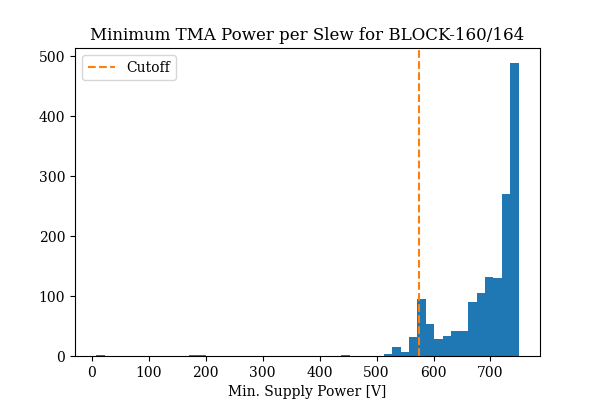

In [176]:
plt.figure(figsize=(6,4))
plt.hist(df.min_power,bins=50)
plt.axvline(575, ls='--',c='C1', label='Cutoff')
plt.legend()
plt.xlabel('Min. Supply Power [V]')
plt.title('Minimum TMA Power per Slew for BLOCK-160/164')
plt.savefig('min_power_all_slews.png')

In [214]:
def make_plots(df_, title_date,name):
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=True, figsize=(12, 4))

    ax1.plot(df_.az_max_vel, df_.min_power,'x',label='azVel')
    ax1.plot(df_.el_max_vel, df_.min_power,'x', label='elVel')
    ax1.axhline(575, ls='--', c='k',label='voltage drop limit')
    ax1.legend()
    #ax1.set_xlim(-1,12)
    ax1.set_xlabel('max Velocity (m/s)')
    ax1.set_ylabel('min supplyPowerVoltage (V)')

    ax2.plot(df_.az_max_acc, df_.min_power,'x',label='azAcc')
    ax2.plot(df_.el_max_acc, df_.min_power,'x',label='elAcc')
    ax2.axhline(575, ls='--', c='k',label='voltage drop limit')
    ax2.legend()
    #ax2.set_xlim(-1,25)
    ax2.set_xlabel('max Acceleration $(m/s^{2})$')
    #ax2.set_ylabel('min supplyPowerVoltage (V)')
               
    ax3.plot(df_.az_max_jerk, df_.min_power,'x',label='azJerk')
    ax3.plot(df_.el_max_jerk, df_.min_power,'x', label='elJerk')
    ax3.axhline(575, ls='--', c='k',label='voltage drop limit')
    ax3.legend()
    #ax3.set_xlim(-100,800)
    ax3.set_xlabel('max Jerk $(m/s^{3})$')
    #ax3.set_ylabel('min supplyPowerVoltage (V)')
               
    fig.suptitle(f'Min. TMA voltage vs. TMA Performance for {title_date}')
    fig.tight_layout()
    plt.savefig(f'{name}.png')

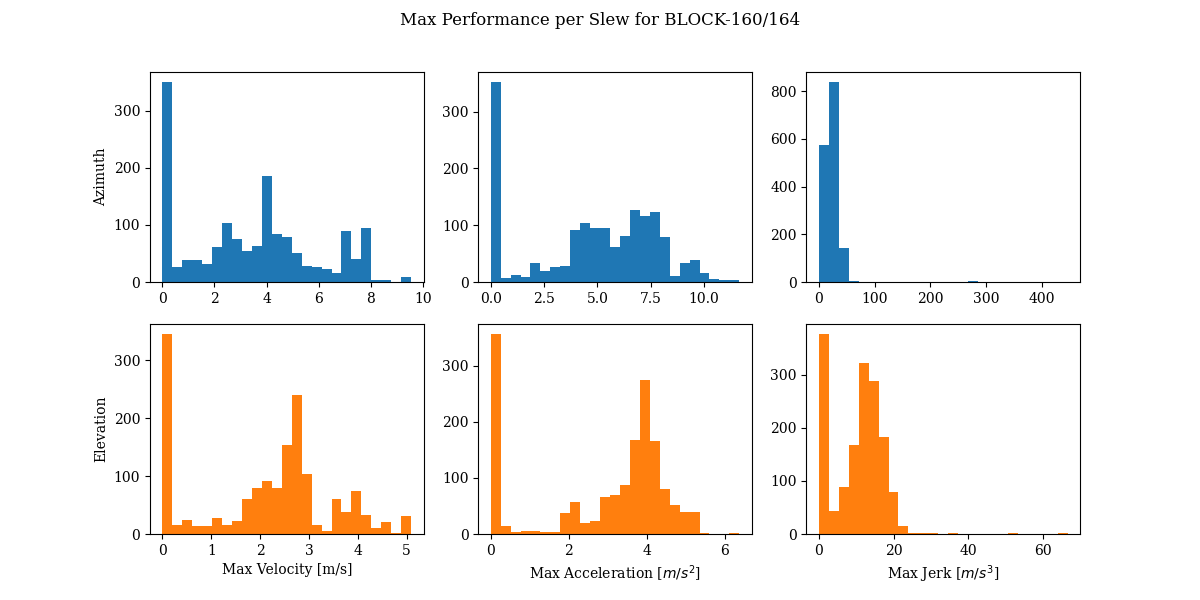

In [190]:
df_ = df
fig, ((ax1,ax2, ax3),(ax4, ax5, ax6)) = plt.subplots(2,3, figsize=(12,6))
ax1.hist(df_.az_max_vel,bins=25,  color='C0', label='AzVel')
ax4.hist(df_.el_max_vel, bins=25,color='C1',label='ElVel')
ax4.set_xlabel('Max Velocity [m/s]')
ax1.set_ylabel('Azimuth')
ax4.set_ylabel('Elevation')

ax2.hist(df_.az_max_acc, bins=25,color='C0',label='AzAcc')
ax5.hist(df_.el_max_acc, bins=25,color='C1',label='ElAcc')
ax5.set_xlabel('Max Acceleration [$m/s^{2}$]')

ax3.hist(df_.az_max_jerk, bins=25,color='C0',label='AzJerk')
ax6.hist(df_.el_max_jerk, bins=25,color='C1',label='ElJerk')
ax6.set_xlabel('Max Jerk [$m/s^{3}$]')

fig.suptitle('Max Performance per Slew for BLOCK-160/164')
plt.savefig('tma_perf_all_slews.png')

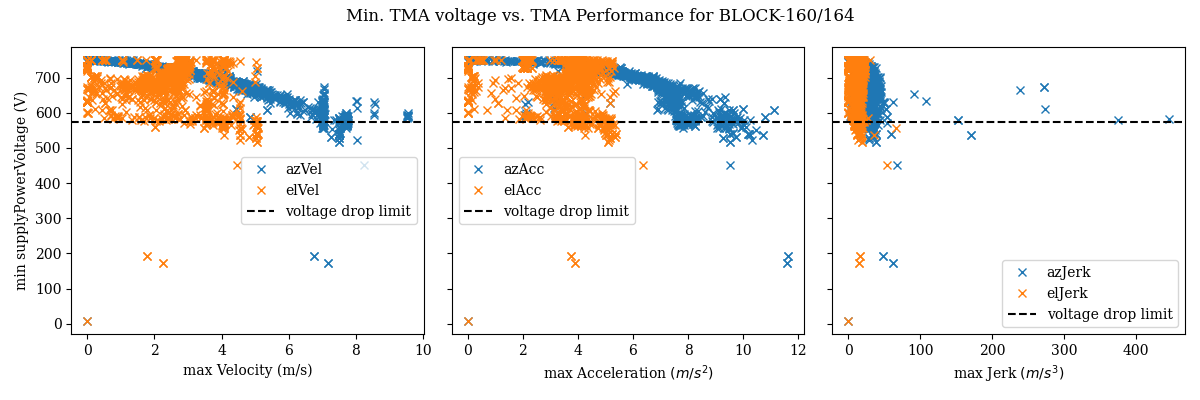

In [215]:
make_plots(df, 'BLOCK-160/164','tma_perf_dec_2023')

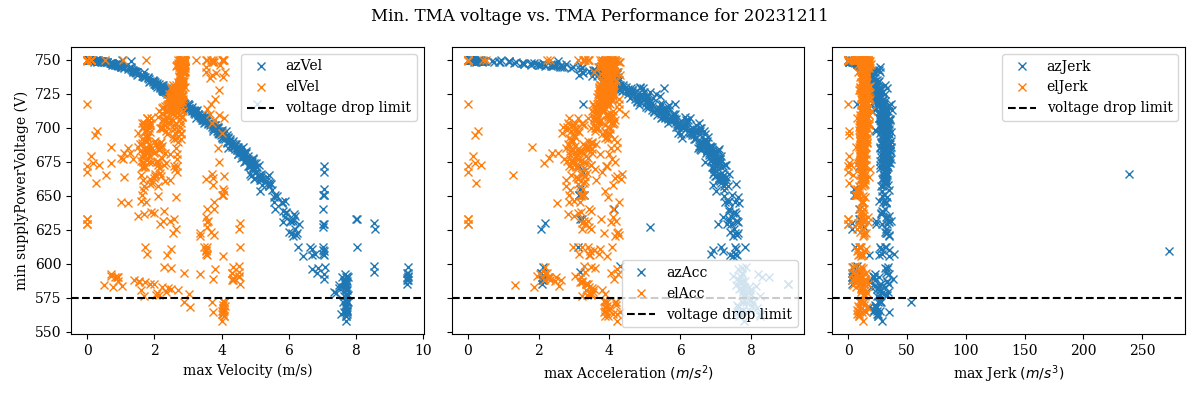

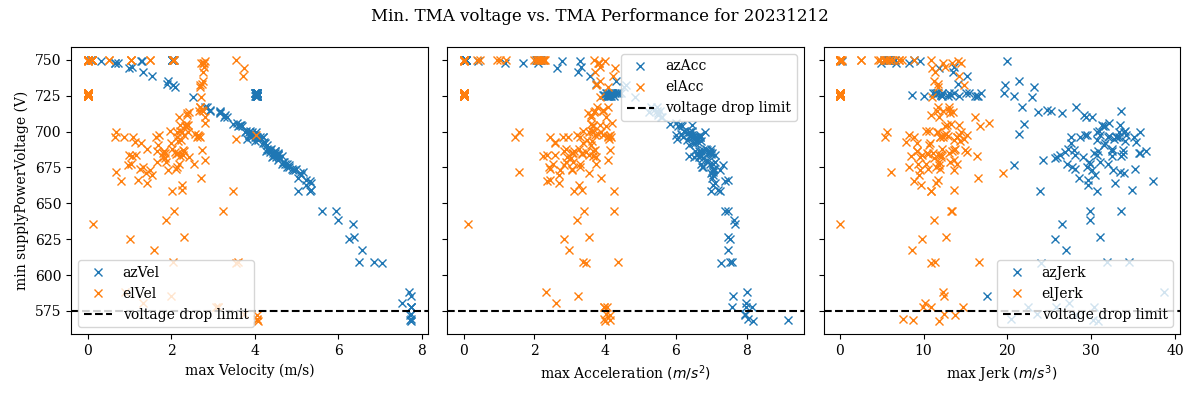

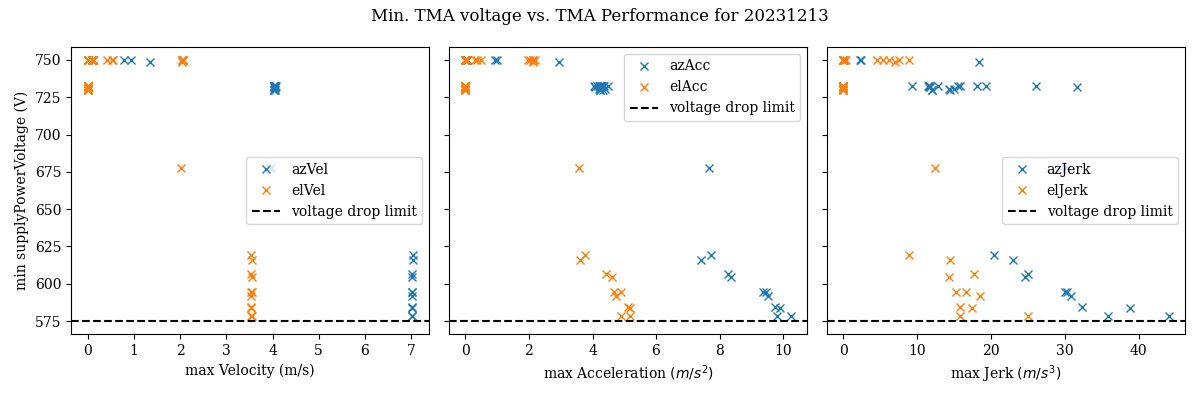

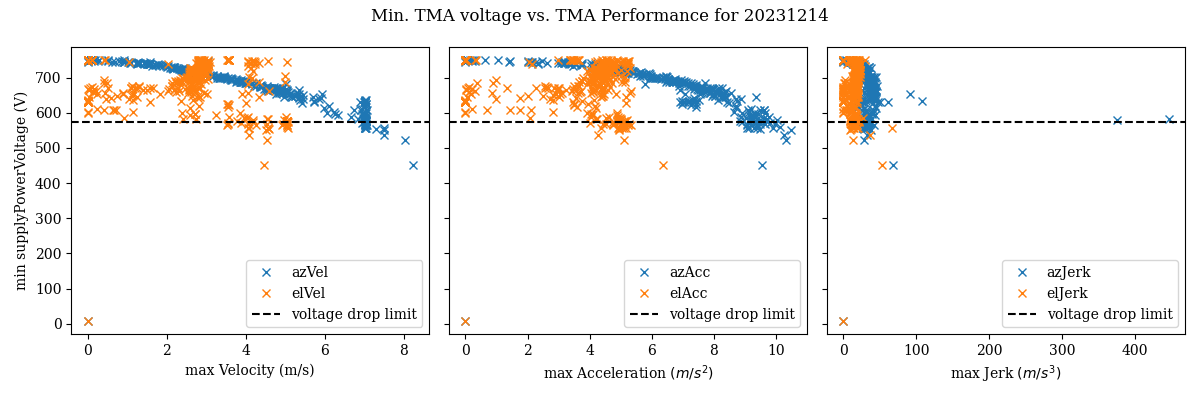

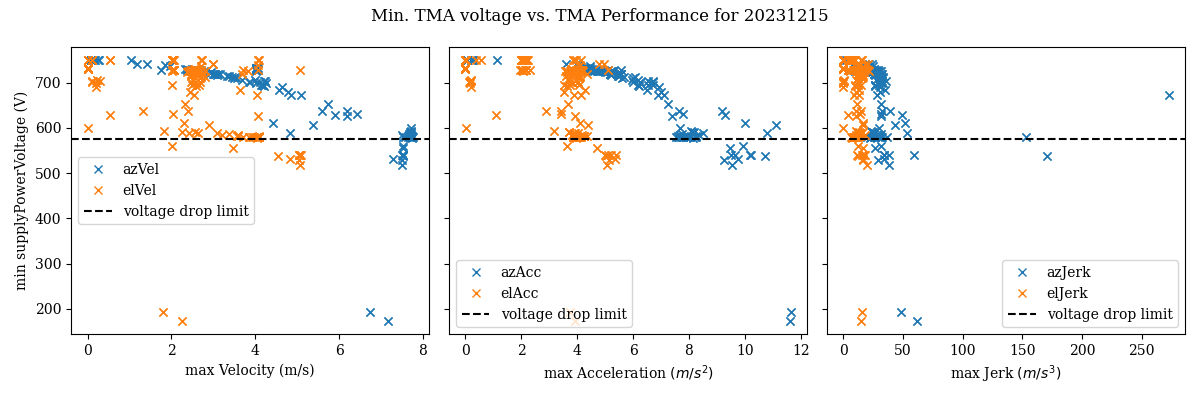

In [216]:
for dayObs in np.unique(df.dayobs):
    df_ = df[df.dayobs == dayObs]
    make_plots(df_, dayObs,f'tma_perf_{dayObs}')

### Low Power Slews

Look at the slews that have a minimum supply power of less than 575 Volts

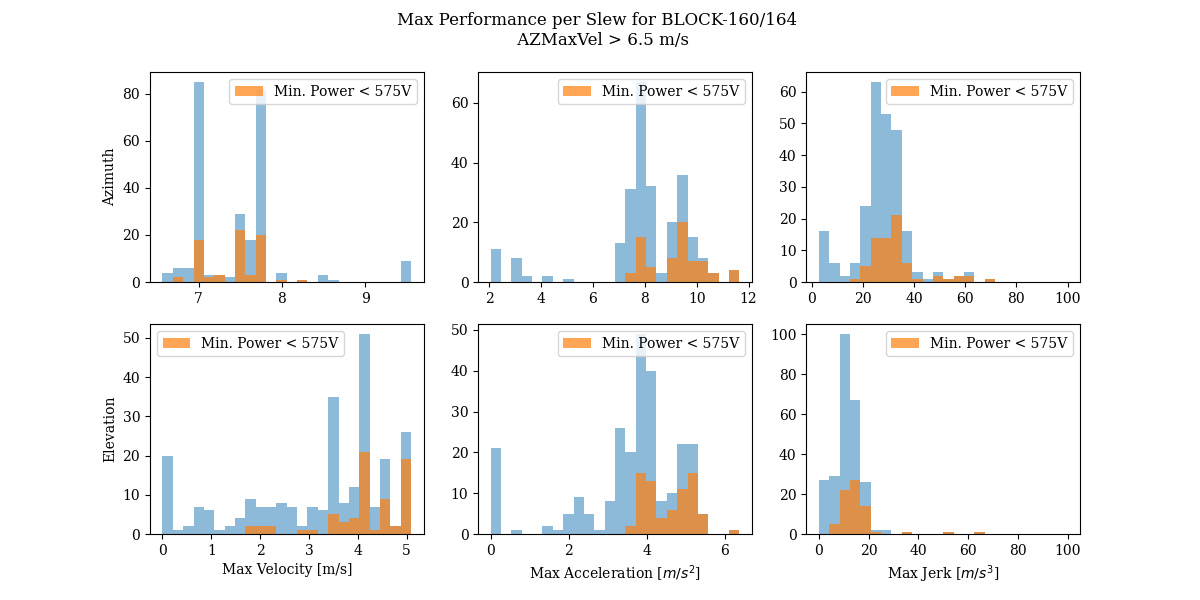

In [195]:
x = df[(df.az_max_vel > 6.5)]
x_ = x[(x.min_power<575)]
fig, ((ax1,ax2, ax3),(ax4, ax5, ax6)) = plt.subplots(2,3, figsize=(12,6))

bins = np.linspace(min(x.az_max_vel), max(x.az_max_vel), 25)
ax1.hist(x.az_max_vel, alpha=0.5, bins=bins)
ax1.hist(x_.az_max_vel, alpha=0.7, bins=bins, label='Min. Power < 575V')

bins = np.linspace(min(x.el_max_vel), max(x.el_max_vel), 25)
ax4.hist(x.el_max_vel, alpha=0.5, bins=bins)
ax4.hist(x_.el_max_vel, alpha=0.7, bins=bins, label='Min. Power < 575V')

ax4.set_xlabel('Max Velocity [m/s]')
ax1.set_ylabel('Azimuth')
ax4.set_ylabel('Elevation')
ax4.legend()
ax1.legend()

bins = np.linspace(min(x.az_max_acc), max(x.az_max_acc), 25)
ax2.hist(x.az_max_acc, alpha=0.5, bins=bins)
ax2.hist(x_.az_max_acc, alpha=0.7, bins=bins, label='Min. Power < 575V')

bins = np.linspace(min(x.el_max_acc), max(x.el_max_acc), 25)
ax5.hist(x.el_max_acc, alpha=0.5, bins=bins)
ax5.hist(x_.el_max_acc, alpha=0.7, bins=bins, label='Min. Power < 575V')
ax5.set_xlabel('Max Acceleration [$m/s^{2}$]')
ax5.legend()
ax2.legend()

bins = np.linspace(min(x.az_max_jerk), 100, 25)
ax3.hist(x.az_max_jerk, alpha=0.5, bins=bins)
ax3.hist(x_.az_max_jerk, alpha=0.7, bins=bins, label='Min. Power < 575V')

bins = np.linspace(min(x.el_max_jerk), 100, 25)
ax6.hist(x.el_max_jerk, alpha=0.5, bins=bins)
ax6.hist(x_.el_max_jerk, alpha=0.7, bins=bins, label='Min. Power < 575V')
ax6.set_xlabel('Max Jerk [$m/s^{3}$]')
ax6.legend()
ax3.legend()

fig.suptitle('Max Performance per Slew for BLOCK-160/164 \n AZMaxVel > 6.5 m/s')
plt.savefig('min_power_less_575_hist.png')

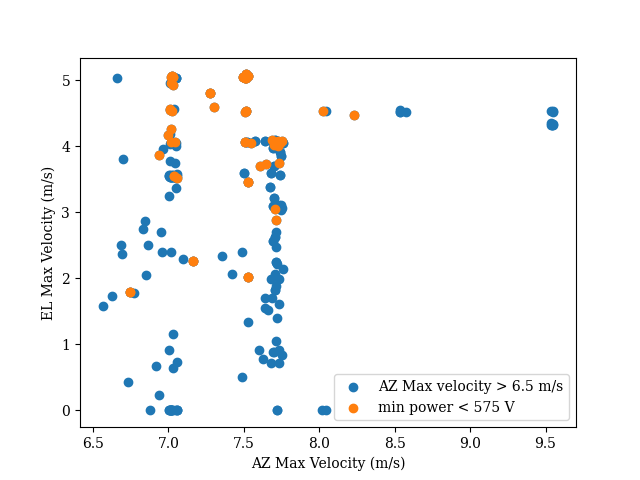

In [196]:
plt.figure()
plt.scatter(x.az_max_vel, x.el_max_vel, label='AZ Max velocity > 6.5 m/s')
plt.scatter(x_.az_max_vel, x_.el_max_vel, label='min power < 575 V')
plt.xlabel('AZ Max Velocity (m/s)')
plt.ylabel('EL Max Velocity (m/s)')
plt.legend()
plt.savefig('el_v_az_vel.png')

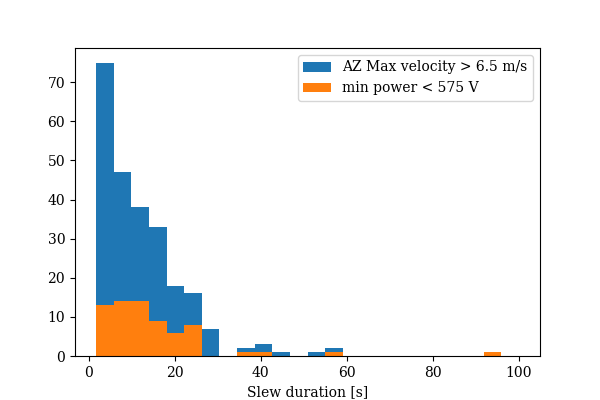

In [211]:
plt.figure(figsize=(6,4))
bins = np.linspace(min(x.duration),100,25)
plt.hist(x.duration, bins=bins, label='AZ Max velocity > 6.5 m/s')
plt.hist(x_.duration, bins=bins, label='min power < 575 V')
plt.xlabel('Slew duration [s]')
plt.legend()
plt.savefig('duration_hist.png')

In [203]:
o = [float(vel.value) for vel in x.begin]
o_ = [float(vel.value) for vel in x_.begin]

In [205]:
np.unique(x.dayobs)

array([20231211, 20231212, 20231213, 20231214, 20231215], dtype=object)

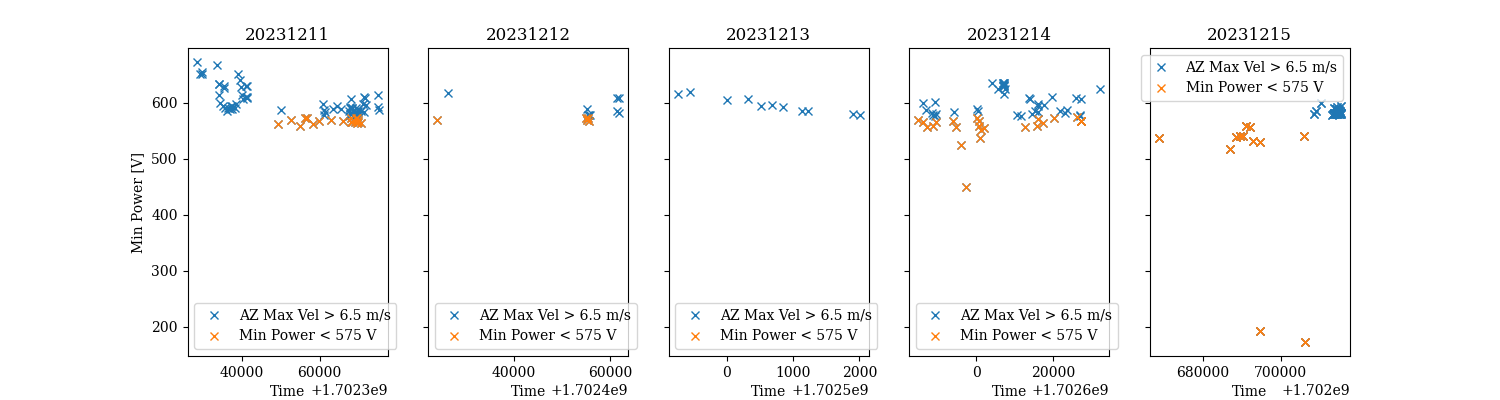

In [210]:
fig, axarr = plt.subplots(1,5, sharey=True, figsize=(15, 4))
ax = axarr.ravel()
for i, day in enumerate(np.unique(x.dayobs)):
    y = x[x.dayobs == day]
    y_ = y[y.min_power<575]
    o = [float(vel.value) for vel in y.begin]
    o_ = [float(vel.value) for vel in y_.begin]
    ax[i].plot(o, y.min_power, 'x',label='AZ Max Vel > 6.5 m/s')
    ax[i].plot(o_, y_.min_power, 'x',label='Min Power < 575 V')
    ax[i].legend()
    ax[i].set_xlabel('Time')
    ax[i].set_title(day)
ax[0].set_ylabel('Min Power [V]')
plt.savefig('time_sequence.png')

In [49]:
id_ = 231
az, el, power_df, data = await data_per_slew(id_, slews[id_],debug=True)
data

[231,
 20231211,
 9.335458040237427,
 <Time object: scale='utc' format='unix' value=1702359736.9030733>,
 <Time object: scale='utc' format='unix' value=1702359746.2385314>,
 566.2,
 7.725084362523001,
 7.775617601514294,
 22.038310493583584,
 4.040557489606306,
 3.994296513276252,
 7.600395626700887]

In [33]:
def smooth_data(az):
    az_time = az.timestamp
    azVelSpline = UnivariateSpline(az.timestamp, az.actualVelocity, s=0) 
    kernel_size = 5
    smoothing_factor=0.2
    kernel = np.ones(kernel_size) / kernel_size
    smoothedAzVel = np.convolve(azVelSpline(az.timestamp), kernel, mode='same')
    azVelSpline_smooth = UnivariateSpline(az.timestamp, smoothedAzVel, s=smoothing_factor)
    plt.figure()
    #plt.plot(az.timestamp, az.actualVelocity,'x',label='data')
    plt.plot(az.timestamp, azVelSpline(az.timestamp),label='spline')
    plt.plot(az.timestamp, smoothedAzVel,label='smooth')
    plt.plot(az.timestamp, azVelSpline_smooth(az.timestamp),label='smooth spline')
    plt.legend()

    kernel_size = 5
    kernel = np.ones(kernel_size) / kernel_size
    azAccSpline = azVelSpline.derivative(n=1)
    azAccSpline_smooth = azVelSpline_smooth.derivative(n=1)
    smoothedAzAcc = np.convolve(azAccSpline_smooth(az_time), kernel, mode='same')
    azAccSpline_convolve = UnivariateSpline(az_time, smoothedAzAcc, s=smoothing_factor)
    plt.figure()
    plt.plot(az.timestamp, azAccSpline(az_time),'--',label='first')
    plt.plot(az.timestamp, azAccSpline_smooth(az_time),'--',label='smoothed')
    plt.plot(az.timestamp, smoothedAzAcc,'--',label='convolved')
    plt.legend()

    kernel_size = 1
    smoothing_factor=0.2
    azJerkSpline1 = azAccSpline.derivative(n=1) 
    azJerkSpline2 = azAccSpline_smooth.derivative(n=1) 
    azJerkSpline3 = azAccSpline_convolve.derivative(n=1) 
    plt.figure()
    plt.plot(az_time, azJerkSpline1(az_time),label='1')
    plt.plot(az_time, azJerkSpline2(az_time),label='smooth')
    plt.plot(az_time, azJerkSpline3(az_time),label='convolved')
    plt.legend()

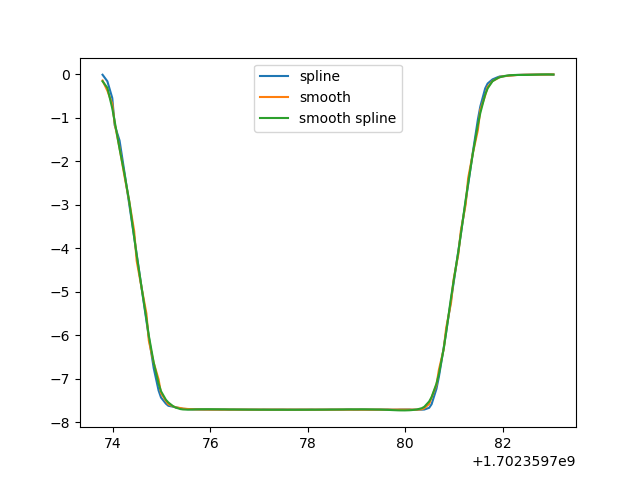

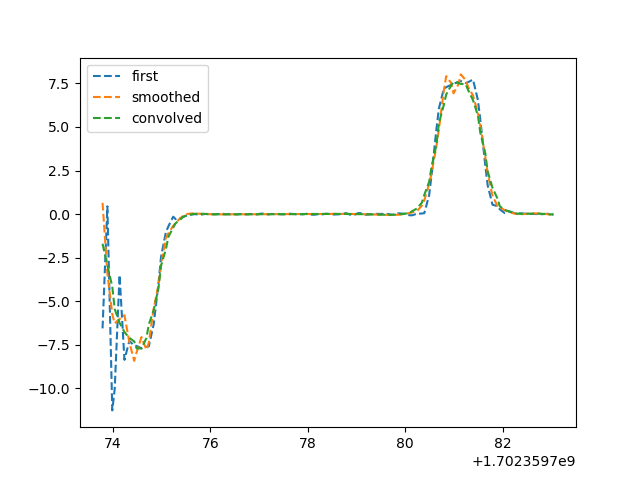

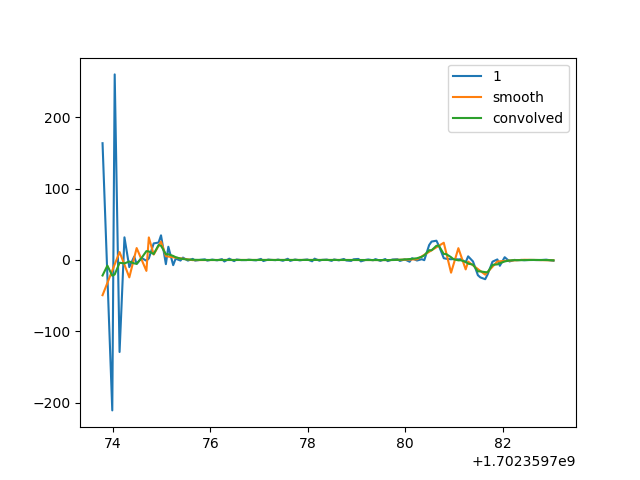

In [50]:
smooth_data(az)